# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [76]:
# import libraries
from pyspark.sql import SparkSession

import pyspark.sql.functions as psqf
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import avg, col, min, max, sum, count, udf, lower

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import  StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import IntegerType, FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import Window

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [170]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [171]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [172]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [173]:
df.count(), len(df.columns)

(286500, 18)

In [174]:
print("Number of  Rows in the dataframe:{}".format(df.count()));
print("Number of  columns in the dataframe:{}".format(len(df.columns)));
print("columns Present in data set in the dataframe{}".format(df.columns));

Number of  Rows in the dataframe:286500
Number of  columns in the dataframe:18
columns Present in data set in the dataframe['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


In [175]:
#discribing all the columns in dataframe
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
auth,286500,None,None,Cancelled,Logged Out
firstName,278154,None,None,Adelaida,Zyonna
gender,278154,None,None,F,M
itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
lastName,278154,None,None,Adams,Wright
length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
level,286500,None,None,free,paid
location,278154,None,None,"Albany, OR","Winston-Salem, NC"


In [176]:
#check for number of null values in each column:

df.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [177]:
#check for false ("null") user IDs
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [178]:
# drop empty userIds
users_not_empty = df.filter(df["userId"] != "")

In [179]:
#difference matches number of null values as it should:
df.count() - users_not_empty.count()

8346

In [180]:
### preliminary analysis

In [181]:
#check for number of users in the dataset:
num_users = users_not_empty.select("userId").distinct().count()
print("Number of users in dataset: {}".format(num_users))

Number of users in dataset: 225


In [182]:
users_not_empty.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [183]:
# check values of level (might be useful for churn definition):
users_not_empty.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [184]:
#checkout how often each "page" is visited:
users_not_empty.groupby('page').agg({'page':'count'}).sort("count(page)").show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|Cancellation Conf...|         52|
|    Submit Downgrade|         63|
|      Submit Upgrade|        159|
|               Error|        252|
|       Save Settings|        310|
|               About|        495|
|             Upgrade|        499|
|                Help|       1454|
|            Settings|       1514|
|           Downgrade|       2055|
|         Thumbs Down|       2546|
|              Logout|       3226|
|         Roll Advert|       3933|
|          Add Friend|       4277|
|     Add to Playlist|       6526|
|                Home|      10082|
|           Thumbs Up|      12551|
|            NextSong|     228108|
+--------------------+-----------+



In [185]:
#We can already see that there is only a small amount of cancleations (52) in our dataset. 63 have downgraded.

In [186]:
#check statistics on the logs we have about our users:
users_not_empty.groupby("userId").count().describe("count").show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|              225|
|   mean|          1236.24|
| stddev|1329.531716432519|
|    min|                6|
|    max|             9632|
+-------+-----------------+



In [187]:
#same for sessionID:
users_not_empty.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



## Define Churn
The page "Cancellation Confirmation" seems appropriate as a first identifier for customers who might have churned (see code below).
We will add a column flagging customers who churned using the following user defined function:

In [188]:
#create churn flag:
churn_event_def = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
#add col to our df:
users_not_empty = users_not_empty.withColumn("churned", churn_event_def("page"))
#defining window:
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# applying window:
users_not_empty = users_not_empty.withColumn("churned", sum("churned").over(windowval))


## Explore Data

In [189]:
# create df of users with churn = true:
user_churned = users_not_empty.groupBy('userId').agg(max('churned').alias("user_churned"))
user_churned.show()

+------+------------+
|userId|user_churned|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
|   124|           0|
|    51|           1|
|     7|           0|
|    15|           0|
|    54|           1|
|   155|           0|
|100014|           1|
|   132|           0|
|   154|           0|
|   101|           1|
|    11|           0|
|   138|           0|
|300017|           0|
|100021|           1|
|    29|           1|
|    69|           0|
|   112|           0|
+------+------------+
only showing top 20 rows



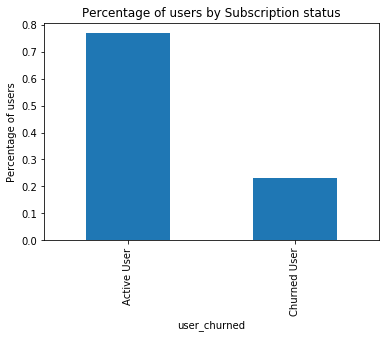

In [190]:
# creat boxplot showing how many % of our useres churned:
churn_count = user_churned.groupby('user_churned').count().toPandas().set_index('user_churned').sort_index()
plt.figure()
(churn_count/churn_count.sum()).plot.bar(legend=None)
labels = ['Active User', 'Churned User']
x_pos = np.arange(len(labels))
plt.xticks(x_pos,labels)
plt.title('Percentage of users by Subscription status')
plt.ylabel('Percentage of users')
plt.show()

In [191]:
#total churned vs active customers:
churn_count

,count
user_churned,
0,173
1,52


In [192]:
# Joining subscription status to the original data frame to analyze potential features
users_not_empty = users_not_empty.join(user_churned, on=['userId'], how='left')

In [193]:
users_not_empty.head()

Row(userId='100010', artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', churned=0, user_churned=0)

#### Comparing churned and active users by page events

In [194]:
#checking the count of each page again
users_not_empty.groupby(['page']).count().orderBy('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|Cancellation Conf...|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [210]:
#grouping by page and user churned / user not churned 
#to see if there is a difference in behaviour between the two subgroups
churn_page_counter = users_not_empty.groupby(['page','user_churned']).count().toPandas()

In [211]:
considered_pages = churn_page_counter.page.tolist()
churn_page_counter = users_not_empty.groupby(['page','user_churned']).count().toPandas()
# NextSong is by far the largest value, so we delete it before calculating sum of the rest
churn_sub_counter = churn_page_counter[~churn_page_counter.page.isin(['NextSong','Cancellation Confirmation','Cancel'])]
# get thea sum of all pages but NextSong
total_pages = churn_sub_counter.groupby(['user_churned']).sum()
# filter for pages we might want to use as potential features
churn_sub_counter = churn_sub_counter[churn_sub_counter.page.isin(considered_pages)]
churn_sub_counter = (churn_sub_counter.set_index(['page', 'user_churned']) / total_pages).reset_index()
churn_sub_counter['user_churned'] = churn_sub_counter['user_churned'].replace({0:'No', 1: 'Yes'})

Text(0.5,0,'Percentage of Events')

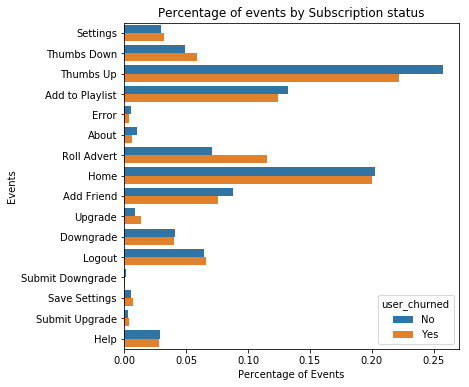

In [212]:
plt.figure(figsize=(6,6))
sns.barplot(y = 'page', x = 'count', data = churn_sub_counter, hue = 'user_churned')
plt.title('Percentage of events by Subscription status')
plt.ylabel('Events')
plt.xlabel('Percentage of Events')

In [213]:
#same visualization for NextPage:
churn_NextSong_counter = churn_page_counter.loc[churn_page_counter.page == 'NextSong']
total_NextSong = churn_NextSong_counter['count'].sum()
churn_NextSong_counter = (churn_NextSong_counter.set_index(['page', 'user_churned']) / total_NextSong).reset_index()
churn_NextSong_counter['user_churned'] = churn_NextSong_counter['user_churned'].replace({0:'No', 1: 'Yes'})
churn_NextSong_counter = churn_NextSong_counter.sort_values(by=['count'], ascending = False)

Text(0.5,0,'Percentage of Events')

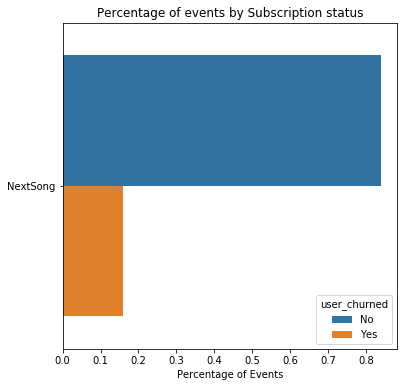

In [214]:
plt.figure(figsize=(6,6))
sns.barplot(y = 'page', x = 'count', data = churn_NextSong_counter, hue = 'user_churned')
plt.title('Percentage of events by Subscription status')
plt.ylabel('')
plt.xlabel('Percentage of Events')

Still subscribed users engange more with the pages that have a posivie Sparkify sentiment.
Those users use the NextSong page alot more and give more thumbs up, add more friends and also add more songs to playlists. It seems to contradict that they upgrade less and downgrade more. However, differences in the counts are small and the total count for those pages is low. 

Users who churned give more thumbs down and have seen the roll advert page significantly more often.

In [215]:
#let's follow up on the significant difference in the NextSong page and see 
#how much time users in our groups (churned / not churned) spend on Sparkify. 
#As an indicator we'll use the amount of songs listened to per user:

songs_per_user = users_not_empty.filter(users_not_empty['song'].isNotNull()).select('userId', 'song').groupby('userId').count()
songs_per_user = songs_per_user.join(user_churned, on=['userId'], how='left')
sns_songs_per_user = songs_per_user.toPandas()
sns_songs_per_user['user_churned']=sns_songs_per_user['user_churned'].replace({0:'Active', 1: 'Churned'})

Text(0.5,0,'')

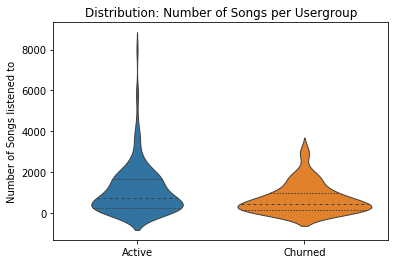

In [216]:
#visualize the distribution of the songs data:
sns.despine(left=True)
ax = sns.violinplot(data=sns_songs_per_user, x="user_churned", y="count",
               split=True, inner="quart", linewidth=1)
ax.set_title('Distribution: Number of Songs per Usergroup')
ax.set_ylabel('Number of Songs listened to')
ax.set_xlabel('')

In [217]:
avg_listens_per_group = songs_per_user.select('count', 'user_churned').groupby('user_churned').agg(avg('count').alias('avg_listens_per_group'))
avg_listens_per_group = avg_listens_per_group.toPandas().set_index('user_churned').sort_index()

In [218]:
avg_listens_per_group

,avg_listens_per_group
user_churned,
0,1108.173410
1,699.884615


Active users do show more listening time on average. However, there are some outliers raising the average which we need to keep in mind.

In [219]:
users_not_empty.filter(users_not_empty['artist'].isNotNull()).select('userId', 'artist').groupby('userId')

In [220]:
users_not_empty.select('artist').show()

+--------------------+
|              artist|
+--------------------+
|Sleeping With Sirens|
|Francesca Battist...|
|              Brutha|
|                null|
|         Josh Ritter|
|               LMFAO|
|         OneRepublic|
|       Dwight Yoakam|
|                null|
|      The Chordettes|
|Coko featuring Ki...|
|            The Cure|
|                null|
|Kid Cudi Vs Crookers|
|                null|
|            Yeasayer|
|             Ben Lee|
|                null|
|  ? & The Mysterians|
|                null|
+--------------------+
only showing top 20 rows



In [221]:
artists_per_user = users_not_empty.filter(users_not_empty['artist'].isNotNull()).select('userId', lower(col('artist'))).dropDuplicates().groupby('userId').count()
artists_per_user = artists_per_user.join(user_churned, on=['userId'], how='left')
sns_artists_per_user = artists_per_user.toPandas()
sns_artists_per_user['user_churned']=sns_artists_per_user['user_churned'].replace({0:'Active', 1: 'Churned'})

Text(0.5,0,'')

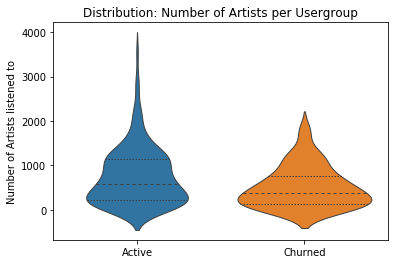

In [222]:
#visualize the distribution of the songs data:
sns.despine(left=True)
ax = sns.violinplot(data=sns_artists_per_user, x="user_churned", y="count",
               split=True, inner="quart", linewidth=1)
ax.set_title('Distribution: Number of Artists per Usergroup')
ax.set_ylabel('Number of Artists listened to')
ax.set_xlabel('')

In [223]:
users_not_empty.filter(users_not_empty.page == 'NextSong').select('userId', lower(col('artist')),'churned').dropDuplicates().groupBy('churned').agg(count('lower(artist)').alias('artists_listened')).show()

+-------+----------------+
|churned|artists_listened|
+-------+----------------+
|      0|          129713|
|      1|           26972|
+-------+----------------+



# Feature Engineering

From our explorations we will derive 8 features for our churn prediction model:

In [37]:
# Number of thumbs up
f1_thumbs_up = users_not_empty.select('userID','page').where(users_not_empty.page == 'Thumbs Up').groupBy('userID').agg(count('page').alias('n_thumb_up'))

# Number of thumbs down
f2_thumbs_down = users_not_empty.select('userID','page').where(users_not_empty.page == 'Thumbs Down').groupBy('userID').agg(count('page').alias('n_thumb_down'))

# Number of adds to playlist
f3_adds_to_playlist = users_not_empty.select('userID','page').where(users_not_empty.page == 'Add to Playlist').groupBy('userID').agg(count('page').alias('adds_to_playlist'))

# Number of adds to friends
f4_adds_to_friend = users_not_empty.select('userID','page').where(users_not_empty.page == 'Add Friend').groupBy('userID').agg(count('page').alias('n_friends_added'))

# Number of Roll Adverts
f5_adds_rolled = users_not_empty.select('userID','page').where(users_not_empty.page == 'Roll Advert').groupBy('userID').agg(count('page').alias('adverts_rolled'))

# Number of Songs played
f6_songs_played = users_not_empty.filter(users_not_empty['song'].isNotNull()).select('userId', 'song').groupBy('userID').agg(count('song').alias('songs_played'))

# Time Spend
f7_listen_time = users_not_empty.filter(users_not_empty['length'].isNotNull()).select('userId', 'length').groupBy('userID').agg(sum('length').alias('listen_time'))

# Artists listened
f8_artists_listened = users_not_empty.filter(users_not_empty.page == 'NextSong').select('userId', 'artist').dropDuplicates().groupBy('userID').agg(count('artist').alias('artists_listened'))

In [54]:
#create churn_status col for the feature df. This is our target col:
churn_status = users_not_empty.select('userId', col('user_churned').alias('label')).dropDuplicates()

In [63]:
#joining all features and chi together:

feature_df  = f1_thumbs_up.join(f2_thumbs_down, on=['userID'], how='outer') \
    .join(f3_adds_to_playlist, on=['userID'], how='outer') \
    .join(f4_adds_to_friend, on=['userID'], how='outer') \
    .join(f5_adds_rolled, on=['userID'], how='outer') \
    .join(f6_songs_played, on=['userID'], how='outer') \
    .join(f7_listen_time, on=['userID'], how='outer') \
    .join(f8_artists_listened, on=['userID'], how='outer') \
    .join(churn_status, on=['userID'], how='outer') \
    .drop('userID')

In [56]:
corr_check = feature_df.toPandas()

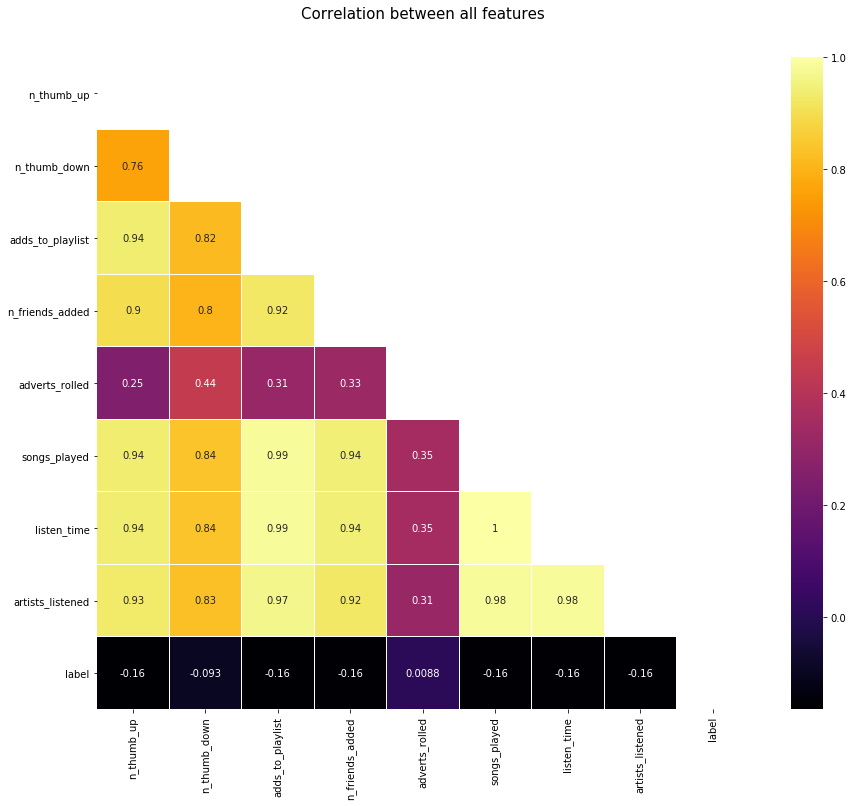

In [161]:
#corrmap = plt.cm.inferno
corr = corr_check.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,12))
plt.title('Correlation between all features', y=1.05, size=15)
sns.heatmap(corr,linewidths=0.1,vmax=1.0, mask=mask,
            square=True, cmap=plt.cm.inferno, linecolor='white', annot=True)

In [43]:
#check for number of null values in each column:

feature_df.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in feature_df.columns]).show()

+----------+------------+----------------+---------------+--------------+------------+-----------+----------------+------------+
|n_thumb_up|n_thumb_down|adds_to_playlist|n_friends_added|adverts_rolled|songs_played|listen_time|artists_listened|churn_status|
+----------+------------+----------------+---------------+--------------+------------+-----------+----------------+------------+
|         5|          22|              10|             19|            18|           0|          0|               0|           0|
+----------+------------+----------------+---------------+--------------+------------+-----------+----------------+------------+



In [64]:
#a few features have missing values. We will fill them with 0's:
feature_df = feature_df.fillna(0)

#### Preparing data and to push to the model. We're going to use VectorAssembler which combines a given list of columns into a single vector column:

In [162]:
features_col = ['n_thumb_up', 
               'n_thumb_down', 
               'adds_to_playlist', 
               'n_friends_added', 
               'adverts_rolled', 
               'songs_played',
               'listen_time', 
               'artists_listened']

In [66]:
#create VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=features_col, outputCol="input_Features")
feature_df = assembler.transform(feature_df)

#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler(inputCol="input_Features", outputCol="features")
scalerModel = scaler.fit(feature_df)
feature_df = scalerModel.transform(feature_df)

In [209]:
feature_df.head()

Row(n_thumb_up=17, n_thumb_down=5, adds_to_playlist=7, n_friends_added=4, adverts_rolled=52, songs_played=275, listen_time=66940.89735000003, artists_listened=252, label=0, input_Features=DenseVector([17.0, 5.0, 7.0, 4.0, 52.0, 275.0, 66940.8974, 252.0]), features=DenseVector([0.2596, 0.3823, 0.214, 0.1943, 2.413, 0.2489, 0.2431, 0.4173]))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [68]:
train, test = feature_df.select('label', 'features').randomSplit([0.9, 0.1], seed=1)

In [69]:
#F1 score was already suggested as the optimization metric. 
#F1 is the main metric taken into consideration since it has all true positive, 
#true negative, false positive, false negative taken into consideration and as such is a
#more balanced metric.
#As about 75% of the users are active our datasets are unbalaned and thus 
#we will follow this suggestion:

f1_evaluation = MulticlassClassificationEvaluator(metricName='f1')

#### Applying logistic regression model

In [71]:
#fitting logistic regression model
logreg = LogisticRegression(maxIter=10)

#Defining the gridsearch parameters:
paramGrid = ParamGridBuilder() \
    .addGrid(logreg.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(logreg.regParam,[0.0, 0.05, 0.1]) \
    .build()

#Defining cross validation parameters:
cv = CrossValidator(estimator=logreg,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluation,
                          numFolds=3)

In [72]:
cvModel_lr = cv.fit(train)

In [73]:
cvModel_lr.avgMetrics

[0.6635906851082103,
 0.6672828709687605,
 0.6695012765791798,
 0.6635906851082103,
 0.6695012765791798,
 0.6695012765791798,
 0.6635906851082103,
 0.6695012765791798,
 0.6695012765791798,
 0.6635906851082103,
 0.6695012765791798,
 0.6695012765791798]

#### Applying random forest model

In [81]:
#fitting random forest model
ranforest = RandomForestClassifier()

#Defining the gridsearch parameters:
paramGrid_ranforest = ParamGridBuilder()\
    .addGrid(ranforest.impurity,['entropy', 'gini']) \
    .addGrid(ranforest.maxDepth,[2, 4, 6, 8]) \
    .build()

#Defining cross validation parameters:
cv_rf = CrossValidator(estimator=ranforest,
                          estimatorParamMaps=paramGrid_ranforest,
                          evaluator=f1_evaluation,
                          numFolds=3)

In [80]:
cvModel_rf = cv_rf.fit(train)

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'


In [82]:
cvModel_rf.avgMetrics

[0.6695012765791798,
 0.6684967676898427,
 0.6790035507239215,
 0.6673572647424711,
 0.6695012765791798,
 0.6891493043656793,
 0.6920420143254228,
 0.6947461594253045]

#### Evaluating the models:

In [83]:
predictions_lr = cvModel_lr.transform(test)
predictions_rf = cvModel_rf.transform(test)

In [84]:
#info taken from: https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels_lr = predictions_lr.select(['prediction','label'])

#select only prediction and label columns
preds_and_labels_lr = preds_and_labels_lr.withColumn('label', col('label').cast(FloatType())).orderBy('prediction')

metrics_lr = MulticlassMetrics(preds_and_labels_lr.rdd.map(tuple))

print(metrics_lr.confusionMatrix().toArray())

[[ 14.   0.]
 [  5.   0.]]


In [169]:
metrics_lr.confusionMatrix().toArray()

array([[ 14.,   0.],
       [  5.,   0.]])

In [85]:
metrics_lr.accuracy

0.7368421052631579

In [86]:
# from: https://stackoverflow.com/questions/58404845/confusion-matrix-to-get-precsion-recall-f1score

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels_rf = predictions_rf.select(['prediction','label'])

#select only prediction and label columns
preds_and_labels_rf = preds_and_labels_rf.withColumn('label', col('label').cast(FloatType())).orderBy('prediction')

metrics_rf = MulticlassMetrics(preds_and_labels_rf.rdd.map(tuple))

print(metrics_rf.confusionMatrix().toArray())

[[ 14.   0.]
 [  4.   1.]]


In [120]:
metrics_rf.accuracy

0.7894736842105263

Model evaluation:

1. The accuracy of both models is similar
2. Random Forest has slightly better f1 score
3. Analyzing the evaluation matrics, we see that logistic regression only predicts active customers (for this small set of test data)
4. For Sparkify this is important because false positive cost more than false negative (users churn which were not expected to churn)
5. Random Forest will therefore be used for  further analysis

#### Checking for feature importance of ...

In [157]:
importance = cvModel_rf.bestModel.featureImportances.values
importance

array([ 0.15299807,  0.17219839,  0.09345736,  0.11250715,  0.21146079,
        0.10205893,  0.09556326,  0.05975605])

Text(0.5,1,'Random Forest feature importances')

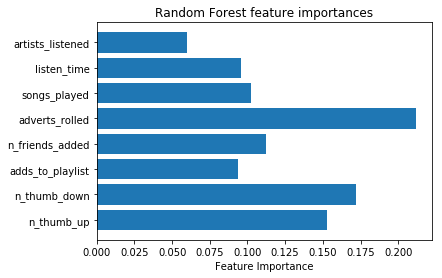

In [160]:
y_pos = np.arange(len(importance))

plt.barh(y_pos, importance, align='center')
plt.yticks(y_pos, ['n_thumb_up', 
                   'n_thumb_down', 
                   'adds_to_playlist', 
                   'n_friends_added', 
                   'adverts_rolled', 
                   'songs_played',
                   'listen_time', 
                   'artists_listened'])
plt.xlabel('Feature Importance')
plt.title('Random Forest feature importances')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.